In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time, sys
import random
import pickle
from tqdm import tqdm

import mlrfit as mf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

In [3]:
rank = 28
mtype = "radkern_hodlr"


with open("../outputs/hpart_uni_radkern_quad_allL_r28_5000_d3.pickle", "rb") as f:
       hpart = pickle.load(f)

with open("../outputs/matrix_radkern_quad_allL_r28_5000_d3.pickle", "rb") as f:
       A = pickle.load(f)

m = A.shape[0]
n = A.shape[1]

# perm_A = A[hpart['rows']['pi'], :][:, hpart['cols']['pi']]
# A = perm_A
# hpart['rows']['pi'] = np.arange(m)
# hpart['cols']['pi'] = np.arange(n)

kerns =  {"exp2": lambda r: np.exp(-r**2),\
          "exp1": lambda r: np.exp(-r),\
          "quad": lambda r: np.power((1 + r**2), -2)}

d = 3
sigma = 0.9
La = 3
kern_type = "quad"
A1, Dist1 = mf.radial_kernel_matrix(d, sigma, n, La, kerns[kern_type])
print(f"{mf.rel_diff(A, A1)=}, {np.allclose(A, A1)=}")

symm = np.allclose(A, A.T) if m==n else False
if symm:
       print(f"MLR storage = {rank * m}")
else:
       print(f"MLR storage = {rank * (m + n)}")

mlr_storage = rank * (m + n)

(array([ 512155, 1531082, 2549980, 3569310, 4591775, 5615185, 6630513]), array([4.01496962e-04, 2.86058423e-01, 5.71715349e-01, 8.57372275e-01,
       1.14302920e+00, 1.42868613e+00, 1.71434305e+00, 1.99999998e+00]))
mf.rel_diff(A, A1)=2.7611563741487552e-17, np.allclose(A, A1)=True
MLR storage = 280000


In [4]:
np.linalg.norm(A1, ord='fro'), np.linalg.norm(A, ord='fro')

(2130.8400919307405, 2130.8400919307405)

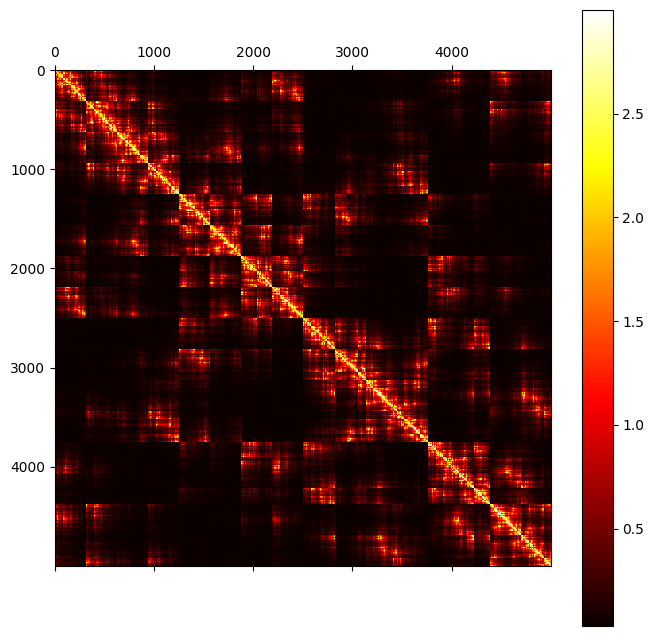

In [5]:
perm_A = A[hpart['rows']['pi'], :][:, hpart['cols']['pi']]
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111)
cax = ax.matshow(perm_A, cmap='hot')
fig.colorbar(cax)
plt.show()

In [6]:
print(np.histogram(A.reshape(-1), 7))

(array([21731231,  1883256,   707230,   335470,   177001,   102105,
          63707]), array([0.03083634, 0.45500138, 0.87916642, 1.30333147, 1.72749651,
       2.15166155, 2.5758266 , 2.99999164]))


In [7]:
assert m == hpart['rows']['pi'].size and n == hpart['cols']['pi'].size
mf.hpart_info_print(hpart)

level=0,  1
    avg_row_bl_size=5000.0, avg_col_bl_size=5000.0
level=1,  2
    avg_row_bl_size=2500.0, avg_col_bl_size=2500.0
level=2,  4
    avg_row_bl_size=1250.0, avg_col_bl_size=1250.0
level=3,  8
    avg_row_bl_size=625.0, avg_col_bl_size=625.0
level=4,  16
    avg_row_bl_size=312.5, avg_col_bl_size=312.5
level=5,  32
    avg_row_bl_size=156.2, avg_col_bl_size=156.2
level=6,  64
    avg_row_bl_size=78.1, avg_col_bl_size=78.1
level=7,  128
    avg_row_bl_size=39.1, avg_col_bl_size=39.1
level=8,  256
    avg_row_bl_size=19.5, avg_col_bl_size=19.5
level=9,  512
    avg_row_bl_size=9.8, avg_col_bl_size=9.8
level=10,  1024
    avg_row_bl_size=4.9, avg_col_bl_size=4.9
level=11,  2048
    avg_row_bl_size=2.4, avg_col_bl_size=2.4
level=12,  4096
    avg_row_bl_size=1.2, avg_col_bl_size=1.2
level=13,  5000
    avg_row_bl_size=1.0, avg_col_bl_size=1.0


In [8]:
rel_tol = 0.0175
tol = rel_tol * np.linalg.norm(A, ord='fro')
tol

37.289701608787965

In [9]:
A_HODLR, A_HODLR_fillin, bl_sizes, count = mf.build_hodlr(hpart, m, n, A, tol)

100%|██████████| 14/14 [00:35<00:00,  2.52s/it]


In [10]:
np.histogram(A_HODLR_fillin.reshape(-1), bins=5)

(array([       0,        0, 25000000,        0,        0]),
 array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]))

In [11]:
# assert (A_HODLR == 0).sum() == 0, print((A_HODLR == 0).sum())

In [12]:
hodlr_storage = mf.get_hodlr_storage(bl_sizes, count, m, n)

In [13]:
np.histogram(bl_sizes[:, 0])

(array([14959,    23,    10,     1,     3,     0,     0,     0,     0,
            2]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]))

In [14]:
(bl_sizes[:, 0]==0).sum(), (bl_sizes[:, 0]==1).sum(),  (bl_sizes[:, 0]==2).sum()

(9622, 5337, 23)

In [15]:
print(f"{rel_tol=},   err={mf.rel_diff(A_HODLR, den=A)},   {hodlr_storage=}")
# rel_tol=0.05,   err=0.6821311918931598,   hodlr_storage=138750
# rel_tol=0.03,   err=0.535480709827685,    hodlr_storage=200001
# rel_tol=0.02,   err=0.4541568284800306,   hodlr_storage=256797
# rel_tol=0.0175, err=0.4065703048661002,   hodlr_storage=281328
# rel_tol=0.015,  err=0.364660892250298,    hodlr_storage=305353
# rel_tol=0.0125, err=0.35454264258681106,  hodlr_storage=334435
# rel_tol=0.01,   err=0.3014143398000552,   hodlr_storage=376665

rel_tol=0.0175,   err=0.40657030486610046,   hodlr_storage=281328


In [16]:
(0.02+0.015)/2

0.0175

In [17]:
print(f"{hodlr_storage=}")
print(f"  {mlr_storage=}")
print(f"       {m * n =}")
print(f"{m*n - hodlr_storage=}")
mlr_storage * 1./ hodlr_storage

hodlr_storage=281328
  mlr_storage=280000
       m * n =25000000
m*n - hodlr_storage=24718672


0.9952795313655235

In [18]:
# LR             0.2276664318990243
# LR+D           0.23281600091200017
# MLR uniform     0.07733073038877397
# MLR bottom      0.06496908623880863
# MLR top         0.09399588315837443

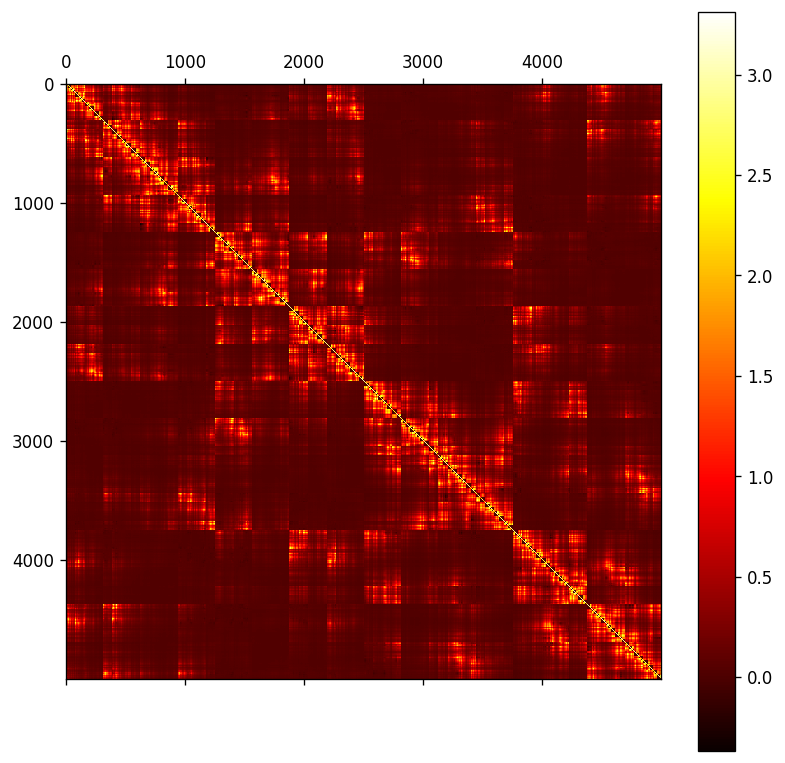

In [19]:
fig = plt.figure(figsize=(8, 8), dpi=120)
ax = fig.add_subplot(111)
cax = ax.matshow(A_HODLR[hpart['rows']['pi'], :][:, hpart['cols']['pi']], cmap='hot')
fig.colorbar(cax)
plt.show()

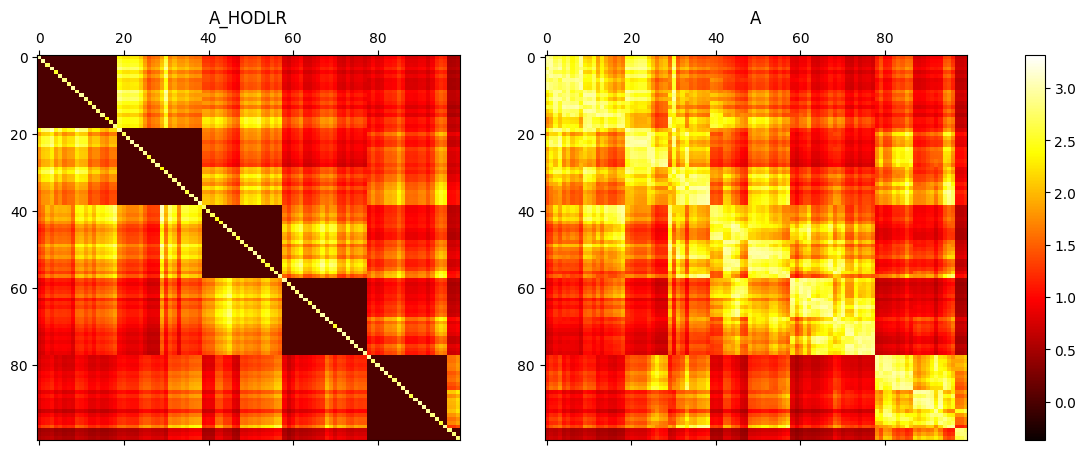

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=100)
vmin = min(A.min(), A_HODLR.min())
vmax = max(A.max(), A_HODLR.max())
perm_A_HODLR = A_HODLR[hpart['rows']['pi'], :][:, hpart['cols']['pi']]
cax1 = axs[0].matshow(perm_A_HODLR[:100,:100], cmap='hot', aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title('A_HODLR')
perm_A = A[hpart['rows']['pi'], :][:, hpart['cols']['pi']]
cax2 = axs[1].matshow(perm_A[:100, :100], cmap='hot', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title('A')

fig.colorbar(cax1, ax=axs, orientation='vertical')
plt.show()

In [21]:
hpart['rows']['lk'][9][:5], hpart['cols']['lk'][9][:5]

(array([ 0,  9, 19, 29, 39]), array([ 0,  9, 19, 29, 39]))

In [22]:
np.linalg.norm((perm_A - perm_A_HODLR)[19:29,19:29], ord='fro'), tol

(25.091918414978338, 37.289701608787965)

In [23]:
a_diags = []
for level in [-1, -2, -3]:
    num_blocks = len(hpart['rows']['lk'][level]) - 1
    a_diags += [np.zeros((m, n))]
    for i, block in enumerate(range(num_blocks)):
        r1, r2 = hpart['rows']['lk'][level][block], hpart['rows']['lk'][level][block+1]
        c1, c2 = hpart['cols']['lk'][level][block], hpart['cols']['lk'][level][block+1]
        a_diags[-1][r1:r2, c1:c2] = 2*np.ones((r2-r1, c2-c1))

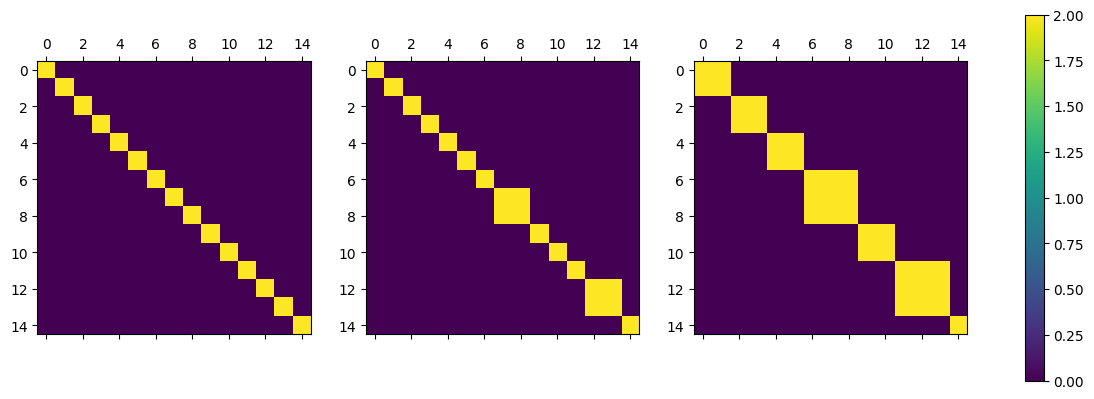

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
max_el = 15
cax1 = axs[0].matshow(a_diags[0][:max_el, :max_el], cmap='viridis')
cax2 = axs[1].matshow(a_diags[1][:max_el, :max_el], cmap='viridis')
cax3 = axs[2].matshow(a_diags[2][:max_el, :max_el], cmap='viridis')

cbar = fig.colorbar(cax2, ax=axs.ravel().tolist(), shrink=0.95)
plt.show()